In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from load_data import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def VGGNet(input_shape):

    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=input_shape, padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model


def train_vgg_model(X_train, y_train, X_eval, y_eval, num_classes):
    
    IMAGE_SIZE = X_train.shape[1]
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    model = VGGNet(input_shape=input_shape)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=SparseCategoricalCrossentropy(),
        # loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=15,
        validation_data=(X_eval, y_eval),
        callbacks=[early_stopping]
    )

    return model, history, X_eval, y_eval

In [ ]:
img_shape = (225, 225)

results = {
    "models": [],
    "histories": [],
    "X_eval": [],
    "y_eval_cat": []
}

# Train on Augmented Dataset
images, labels, label_map = load_dataset(img_shape[0], img_shape[0])
X_train_aug, y_train_aug, X_eval, y_eval, X_test, y_test = split_and_augment_dataset(images, labels, eval_set=True, random_state=42)

num_classes = len(label_map)
num_layers_to_freeze = 50
model_aug, history_aug, X_eval_aug, y_eval_cat_aug = train_vgg_model(X_train_aug, y_train_aug, X_eval, y_eval, num_classes)

results["models"].append(model_aug)
results["histories"].append(history_aug)
results["X_eval"].append(X_eval_aug)
results["y_eval_cat"].append(y_eval_cat_aug)


# Train on Non-Augmented Dataset
X_non_aug, y_non_aug, _ = load_dataset(img_shape[0], img_shape[0])
X_train_non_aug, X_temp, y_train_non_aug, y_temp = train_test_split(X_non_aug, y_non_aug, test_size=0.4, random_state=42)
X_test_non_aug, X_eval_non_aug, y_test_non_aug, y_eval_non_aug = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model_non_aug, history_non_aug, X_eval_non_aug, y_eval_cat_non_aug = train_vgg_model(X_train_non_aug, y_train_non_aug, X_eval_non_aug, y_eval_non_aug, num_classes)

results["models"].append(model_non_aug)
results["histories"].append(history_non_aug)
results["X_eval"].append(X_eval_non_aug)
results["y_eval_cat"].append(y_eval_cat_non_aug)


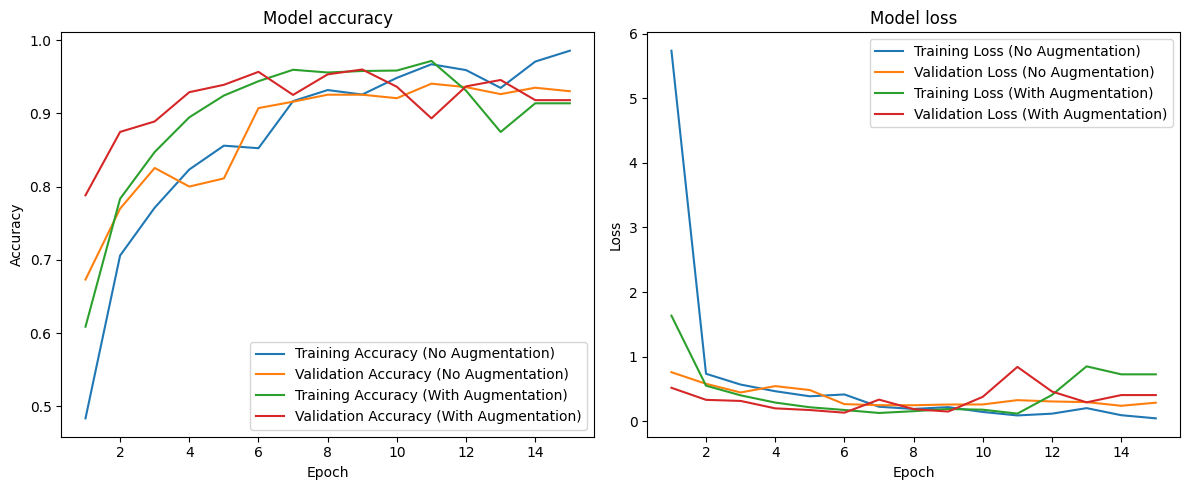

In [ ]:
def plot_training_results(results):
    epochs = range(1, len(results["histories"][0].history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["histories"][0].history['accuracy'], 'r--', label='Training Accuracy (augmented dataset)')
    plt.plot(epochs, results["histories"][0].history['val_accuracy'], 'r-', label='Validation Accuracy (augmented dataset)')
    plt.plot(epochs, results["histories"][1].history['accuracy'], 'b--', label='Training Accuracy (original dataset)')
    plt.plot(epochs, results["histories"][1].history['val_accuracy'], 'b-', label='Validation Accuracy (original dataset)')
    plt.title('Model accuracy (VGG)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["histories"][0].history['loss'], 'r--', label='Training Loss (augmented dataset)')
    plt.plot(epochs, results["histories"][0].history['val_loss'], 'r-', label='Validation Loss (augmented dataset)')
    plt.plot(epochs, results["histories"][1].history['loss'], 'b--', label='Training Loss (original dataset)')
    plt.plot(epochs, results["histories"][1].history['val_loss'], 'b-', label='Validation Loss (original dataset)')
    plt.title('Model loss (VGG)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('img/vgg_experiment_learning_curve.png', dpi=300)
    plt.show()

plot_training_results(results)

In [ ]:
def evaluate_models(results):
    for i, (model, X_eval, y_eval_cat) in enumerate(zip(results["models"], results["X_eval"], results["y_eval_cat"])):
        loss, accuracy = model.evaluate(X_eval, y_eval_cat, verbose=0)
        print(f"VGG Model {i+1} ({'Without' if i % 2 else 'With'} Augmentation): Evaluation Loss: {loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")

evaluate_models(results)

VGG model 1 (Without Augmentation): Evaluation Loss: 0.2892, Evaluation Accuracy: 0.9302
VGG model 2 (With Augmentation): Evaluation Loss: 0.1520, Evaluation Accuracy: 0.9598


Now we can see that augmentation has improved the results, therefore we will do the final test on augmented dataset

In [ ]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
X_eval_augmented, y_eval_augmented = augment_data(X_eval, y_eval)

X_train_final = np.concatenate((X_train_aug, X_eval_augmented), axis=0)
y_train_final = np.concatenate((y_train_aug, y_eval_augmented), axis=0)

In [ ]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
num_classes = len(np.unique(y_train_final))
model_full, history_full, _, _ = train_vgg_model(X_train_final, y_train_final, X_test, y_test, num_classes)

In [ ]:
loss, accuracy = model_full.evaluate(X_test, y_test)
print("FINAL RUN - VGG MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

In [ ]:
import os

save_dir = "final_results/VGG"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model
model_save_path = os.path.join(save_dir, "model_vgg.h5")
model_full.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the history
history_save_path = os.path.join(save_dir, "history_vgg.json")
with open(history_save_path, 'w') as f:
    json.dump(history_full.history, f)
print(f"Training history saved to {history_save_path}")

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_full.history['accuracy']) + 1)
train_loss = history_full.history['loss']
train_accuracy = history_full.history['accuracy']
test_loss = history_full.history.get('val_loss', None)
test_accuracy = history_full.history.get('val_accuracy', None)

# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and test accuracy
ax1.plot(epochs, train_accuracy, 'r--', label='Training Accuracy')
if test_accuracy is not None:
    ax1.plot(epochs, test_accuracy, 'b-', label='Test Accuracy')
ax1.set_title('Accuracy - VGG model (augmented dataset)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting training and test loss
ax2.plot(epochs, train_loss, 'r--', label='Training Loss')
if test_loss is not None:
    ax2.plot(epochs, test_loss, 'b-', label='Test Loss')
ax2.set_title('Loss - VGG model (augmented dataset)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.savefig('img/vgg_final_learning_curve.png', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
y_pred = model_full.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reverse the label map to get a mapping from index to class name
index_to_class_name = {v: k for k, v in label_map.items()}

# Convert class indices to class names
y_test_names = np.vectorize(index_to_class_name.get)(y_test)
y_pred_classes_names = np.vectorize(index_to_class_name.get)(y_pred_classes)

# Compute the confusion matrix
cm = confusion_matrix(y_test_names, y_pred_classes_names, labels=list(label_map.keys()))

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - VGG (augmented dataset)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('img/vgg_final_confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
print('Classification Report (VGG MODEL):\n', classification_report(y_test, y_pred_classes))


In [ ]:
print("Once again...\nFINAL RUN - VGG MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)